### INPUTS

In [1]:
sample_size = 30000 #30000

### Imports

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/export_flat_form.csv')

### Helper functions

In [4]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def split_random(a, n = 0.5):
    msk = np.random.rand(len(a)) < n
    return a[msk].copy(), a[~msk].copy()


def split_random_masks(a, n1, n2):
    msk = np.random.rand(len(a)) < (n1 + n2)
    msk1 = ((np.random.rand(len(a)) < n1/(n1+n2)) & msk)
    msk2 = (~msk1 & msk)
    return ~msk, msk1, msk2


def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = ["rmse(trn):",rmse(m.predict(X_train), y_train), " rmse(val):",rmse(m.predict(X_valid), y_valid),
                " scr(trn):",m.score(X_train, y_train), " scr(val):",m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Preproccessing

### Dates Filter

In [5]:
df.date = pd.to_datetime(df["date"])
dates_mask = (df.date > '2020-10-01')
df_newer_dates = df.loc[dates_mask]
dates_ordinal_newer = pd.Series([x.toordinal() for x in df_newer_dates.date])

[Text(737660.0, 0, '2020-08-23'),
 Text(737700.0, 0, '2020-10-02'),
 Text(737740.0, 0, '2020-11-11'),
 Text(737780.0, 0, '2020-12-21')]

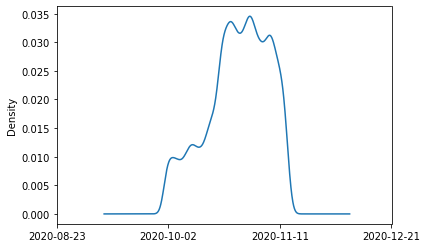

In [6]:
ax = dates_ordinal_newer.plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

In [7]:
min_date = df.date.min()
max_date = df.date.max()
print("pre-filter")
print("oldest match: "+ str(min_date)+"   newest match: "+str(max_date))
min_date = df_newer_dates.date.min()
max_date = df_newer_dates.date.max()
print("post-filter")
print("oldest match: "+ str(min_date)+"   newest match: "+str(max_date))

pre-filter
oldest match: 2020-01-01 00:54:03   newest match: 2020-11-14 12:54:01
post-filter
oldest match: 2020-10-01 00:02:11   newest match: 2020-11-14 12:54:01


### Weight by Date Feature
Here we add a column, which shows days elapsed from the oldest match in set. We will later use this if needed for weighing model inputs.

In [8]:
df_newer_dates = df_newer_dates.assign(weeks_elapsed = (df_newer_dates.date.dt.isocalendar().week - min_date.week))

In [9]:
#could mb get patch dates info table and do weights around that:
#match_date is between patch_date1 and patch_date2
#and so on weights based on next patch index

In [10]:
print(df_newer_dates.shape)
df_raw = df_newer_dates.sample(n = sample_size, random_state = 1, axis = 0)
print(df_raw.shape)
df_raw.reset_index(drop=True, inplace=True)
#print(df_raw.tail())

(45855, 15)
(30000, 15)


#### Drop matches containing least popular heroes

In [11]:
winner_cols = ['winnerA', 'winnerB', 'winnerC', 'winnerD', 'winnerE']
loser_cols = ['loserA', 'loserB', 'loserC', 'loserD', 'loserE']
train_cats(df_raw)
hero_names = df_raw['winnerA'].cat.categories
hero_cols = winner_cols + loser_cols

In [12]:
#df['winnerA'].value_counts()
#list(hero_names)

In [13]:
def drop_low_encounters(threshold = 0.2):
    ncp = pd.DataFrame()
    ncp = ncp.assign(names = list(hero_names))
    ncp = ncp.set_index("names")
    for col in hero_cols:
        cnts = df[col].value_counts()
        #print(cnts.iloc[:1])
        #ncp[col] = df[col].value_counts()
        ncp = pd.concat([ncp, df[col].value_counts()], axis = 1)
    ncp["total"] = ncp.sum(axis=1)
    names_to_drop = ncp.nsmallest(n=int(len(hero_names) * threshold), columns=["total"], keep="all")
    names_to_drop.index.name = 'names'
    names_to_drop = names_to_drop.reset_index()
    ntd = names_to_drop.names.to_list()
    mask = df_raw[hero_cols].isin(ntd)
    mask = mask.any(1)
    return df_raw[~mask]

#df_raw = drop_low_encounters(threshold = 0.2)
#df_raw = df_raw.reset_index(drop=True)
#hero_names = df_raw['winnerA'].cat.categories
#a, b = df_raw.shape
#print("new shape: ",df_raw.shape, ",  Dataset shrunk to ", round(a/sample_size*100, 2), "%")

### Feature Transform

#### Mixing up Y

In [14]:
invert_ratio = 0.5
#n_inv = int(len(df_raw) * invert_ratio)
df_standard, df_inverted = split_random(df_raw, n=invert_ratio)
df_inverted = df_inverted.rename(columns={"winnerA": "loserA", "winnerB": "loserB", "winnerC": "loserC", "winnerD": "loserD", "winnerE": "loserE",
                            "loserA": "winnerA", "loserB": "winnerB", "loserC": "winnerC", "loserD": "winnerD", "loserE": "winnerE"})
#df.loc[idx] = df.loc[idx].rename(columns={'R':'L','L':'R'})
df_inverted['outcome'] = 0
df_mixed = df_standard.append(df_inverted)
#but to preserve relevancy to date, need to reorder by date:
#df_mixed = df_mixed.sort_values(by='date')
print(df_mixed.outcome.mean())
print(df_mixed.shape)

0.4978666666666667
(30000, 15)


In [15]:
tmp = df_mixed[-1:].transpose()
tmp.columns = ["data"]
print(tmp[tmp['data']==True])

Empty DataFrame
Columns: [data]
Index: []


In [16]:
test_output_df = df_mixed.drop(["date", "weeks_elapsed"], axis = 1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in test_output_df.columns:
    test_output_df[col] = le.fit_transform(test_output_df[col])
#print(test_output_df.head())
#test_output_df.to_csv("data/test_raw_df.csv")

In [17]:
train_cats(df_mixed)
print([len(df_mixed[x].cat.categories) for x in df.columns[1:13]])
heroes_total = max(hero_names)
map_names = df_mixed['game_map'].cat.categories
#clear up memory:
#dates_ordinal_newer = 0
#dates_ordinal = 0
#df = pd.DataFrame()
#df_raw = pd.DataFrame()
#df_standard = pd.DataFrame()
#df_inverted = pd.DataFrame()

[14, 2, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87]


##### Lists for indexing uses

In [18]:
mns = [x[1] for x in list(enumerate(map_names))]
yhns = ['yours_'+x[1] for x in list(enumerate(hero_names))]
thns = ['theirs_'+x[1] for x in list(enumerate(hero_names))]
col_names =mns+yhns+thns

#### Helper transform functions

In [19]:
def hero_hot_transform(game_map = '', winners = [], losers = [], bans = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = int(df_mixed['game_map'].cat.categories.get_loc(game_map))
    new_row = new_row.append(pd.Series(game_map_index, index = ['game_map'], dtype = 'int8'))
    return new_row


def hero_one_hot(game_map = '', winners = [], losers = []):
    new_row = pd.Series(index = col_names, dtype = 'boolean')
    new_row[:] = False
    for x in hero_names:
        if x in winners:
            new_row['yours_'+x] = True
        if x in losers:
            new_row['theirs_'+x] = True
    new_row[game_map] = True
    return new_row

##### Run the actual transforms
This take a long time. So it would be best to have intermediate saving / loading of the transformed data. But after models are finalized, this can be done in data gathering step, so no need for now.

In [20]:
def minHotTransform():
    colmn_names = [a for a in hero_names]+['game_map']
    dummies_data = pd.DataFrame(columns = colmn_names, dtype = 'int8')
    for index in range(0, int(len(df_mixed))): #
        game_map = df_mixed['game_map'].iloc[index]
        #game_type = df_mixed['game_type'].iloc[index]

        winners = list(df_mixed[winner_cols].iloc[index].astype(str))
        losers = list(df_mixed[loser_cols].iloc[index].astype(str))
        dummies_data = dummies_data.append(hero_hot_transform(game_map = game_map, winners = winners, losers = losers), ignore_index=True)
    return dummies_data
    
def fullHotTransform():
    dummies_data = pd.DataFrame(columns = col_names, dtype = 'boolean')
    for index in range(0, int(len(df_mixed))): #
        game_map = df_mixed['game_map'].iloc[index]
        #game_type = df_mixed['game_type'].iloc[index]

        winners = list(df_mixed[winner_cols].iloc[index].astype(str))
        losers = list(df_mixed[loser_cols].iloc[index].astype(str))
        dummies_data = dummies_data.append(hero_one_hot(game_map = game_map, winners = winners, losers = losers), ignore_index=True)
    return dummies_data

In [21]:
%%time
#dummies_data = fullHotTransform()
dummies_data = fullHotTransform()

CPU times: user 28min 37s, sys: 9.07 s, total: 28min 46s
Wall time: 29min 13s


In [22]:
#dummies_data = pd.concat([dummies_data, df_mixed[['outcome']].astype(bool)], axis = 1)
dummies_data = pd.concat([dummies_data, df_mixed[['outcome']].astype(bool)], axis = 1)

In [23]:
#print(dummies_data.yours_Valla.sum())
#print(dummies_data.dtypes)
#print(dummies_data.shape)
#dummies_data.tail()

In [24]:
def print_last(df):
    tmp = df[-1:].transpose()
    tmp.columns = ["data"]
    print(tmp[tmp['data']==True])
#print_last(dummies_data)

In [25]:
def find_row(df):
    l = ["Falstad","Sonya","Gall","Cho","Stukov"]
    cols = ['yours_'+x for x in l]
    tmp_row = df[df[cols].all(1)]
    tmp = tmp_row.transpose()
    tmp.columns = ["data"]
    print(tmp[tmp['data']==True])
#find_row(dummies_data)

##### Finally export the result to a CSV

In [26]:
dummies_data.to_csv("data/transform_hot_full.csv")
#dummies_data.to_csv("data/transform_hot_full_shrunk.csv")
#dummies_data.to_csv("data/transform_hot_mini.csv")